In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point
from shapely.ops import unary_union
import distinctipy as dpy
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.colors as colors
from pyproj import CRS

**First step** Normalice the timestay of each individual, so the sum of the timestay of each individual is 30 (removing the indivuals with no timestay)




Here we load the shapefiles of the EEZ and the continental shelf.

In [2]:
EEZshapefile = gpd.read_file("../data/EEZ shapefile/EEZ_land_v2_201410.shp")
EEZshapefile.drop(["OBJECTID", "Changes", "Shape_Leng", "Shape_Area"], axis=1, inplace=True)
Continets = gpd.read_file("../data/Continents/ref-coastline-2016-60m.shp/COAS_RG_60M_2016_4326.shp/COAS_RG_60M_2016_4326.shp")
# Define the complete world
Continent_geometry = unary_union(Continets.geometry)
EEZshapefile["continental_geometry"] = EEZshapefile.geometry.intersection(Continent_geometry)
EEZshapefile["EEZ_geometry"] = EEZshapefile.geometry
EEZshapefile["marine_geometry"] = EEZshapefile.geometry.difference(EEZshapefile.continental_geometry)
EEZshapefile.drop(columns="geometry", axis=1, inplace=True)
EEZshapefile.set_geometry("marine_geometry", inplace=True)

highseas_points = []

# construct the boundaries of the high seas as a list of points of the square bounding box

for lat in np.arange(-90, 90.5, 0.5):
    highseas_points.append(Point(-180., lat))

for lon in np.arange(-180, 180.5, 0.5):
    highseas_points.append(Point(lon, 90.))

for lat in np.arange(90, -90.5, -0.5):
    highseas_points.append(Point(180., lat))

for lon in np.arange(180, -180.5, -0.5):
    highseas_points.append(Point(lon, -90.))

HighSeasPoly = Polygon(highseas_points) - EEZshapefile.EEZ_geometry.unary_union

#Add the high seas to the EEZ shapefile
EEZshapefile = gpd.GeoDataFrame(
    pd.concat([EEZshapefile, 
               gpd.GeoDataFrame({"ISO_3digit": "-1",
                    "Country": "-1",
                    "continental_geometry": Polygon([]),
                    "EEZ_geometry": HighSeasPoly,
                    "marine_geometry": HighSeasPoly
                    }, index=[0])])).reset_index(drop=True)

EEZshapefile.set_geometry("continental_geometry", inplace=True)



In [3]:
EEZshapefile

,ISO_3digit,Country,continental_geometry,EEZ_geometry,marine_geometry
0,-,Conflict zone Japan/Russia,"MULTIPOLYGON (((145.56500 43.99100, 145.63900 ...","POLYGON ((149.156571113 45.49545062500005, 149...","POLYGON ((149.156571113 45.49545062500005, 149..."
1,-,Conflict zone Japan/South Korea,POLYGON EMPTY,"POLYGON ((134.2216315950001 39.87854129500005,...","POLYGON ((134.2216315950001 39.87854129500005,..."
2,-,Joint regime Japan/Korea,POLYGON EMPTY,"POLYGON ((126.2457067390001 30.13313987000004,...","POLYGON ((126.2457067390001 30.13313987000004,..."
3,-,Conflict zone China/Japan/Taiwan,"POLYGON ((123.54600 25.88900, 123.68100 25.711...","POLYGON ((122.900096165 25.22987522200003, 122...","POLYGON ((122.900096165 25.22987522200003, 122..."
4,-,Spratly Islands,"POLYGON ((114.28500 11.23300, 114.48200 11.009...","POLYGON ((112.2398926440001 13.24706771000007,...","POLYGON ((112.2398926440001 13.24706771000007,..."
...,...,...,...,...,...
257,SSD,South Sudan,"POLYGON ((34.09138 9.48753, 34.09416 9.45472, ...","POLYGON ((34.09138136600006 9.487534912000058,...",POLYGON EMPTY
258,VTC,Vatican City,"POLYGON ((12.45669 41.90139, 12.45014 41.90089...","POLYGON ((12.45669125900002 41.90139120600003,...",POLYGON EMPTY
259,ITA,Italy,"MULTIPOLYGON (((12.13302 47.01256, 12.13611 46...","POLYGON ((12.13301820000004 47.01256413000004,...",MULTIPOLYGON (((13.80221823100004 45.586391179...
260,KIR,Kiribati,"MULTIPOLYGON (((-159.39900 4.06500, -159.10400...","POLYGON ((-159.374622539 7.917728175000036, -1...","POLYGON ((-159.374622539 7.917728175000036, -1..."


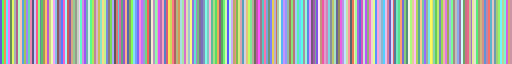

In [4]:
import distinctipy as dpy

# random_colors = dpy.get_colors(len(EEZshapefile.Country.unique()))
random_cmap = dpy.get_colormap(
    dpy.get_colors(
        len(EEZshapefile.Country.unique()), 
        rng=42,
        pastel_factor=0.5,
        )
        )

random_cmap

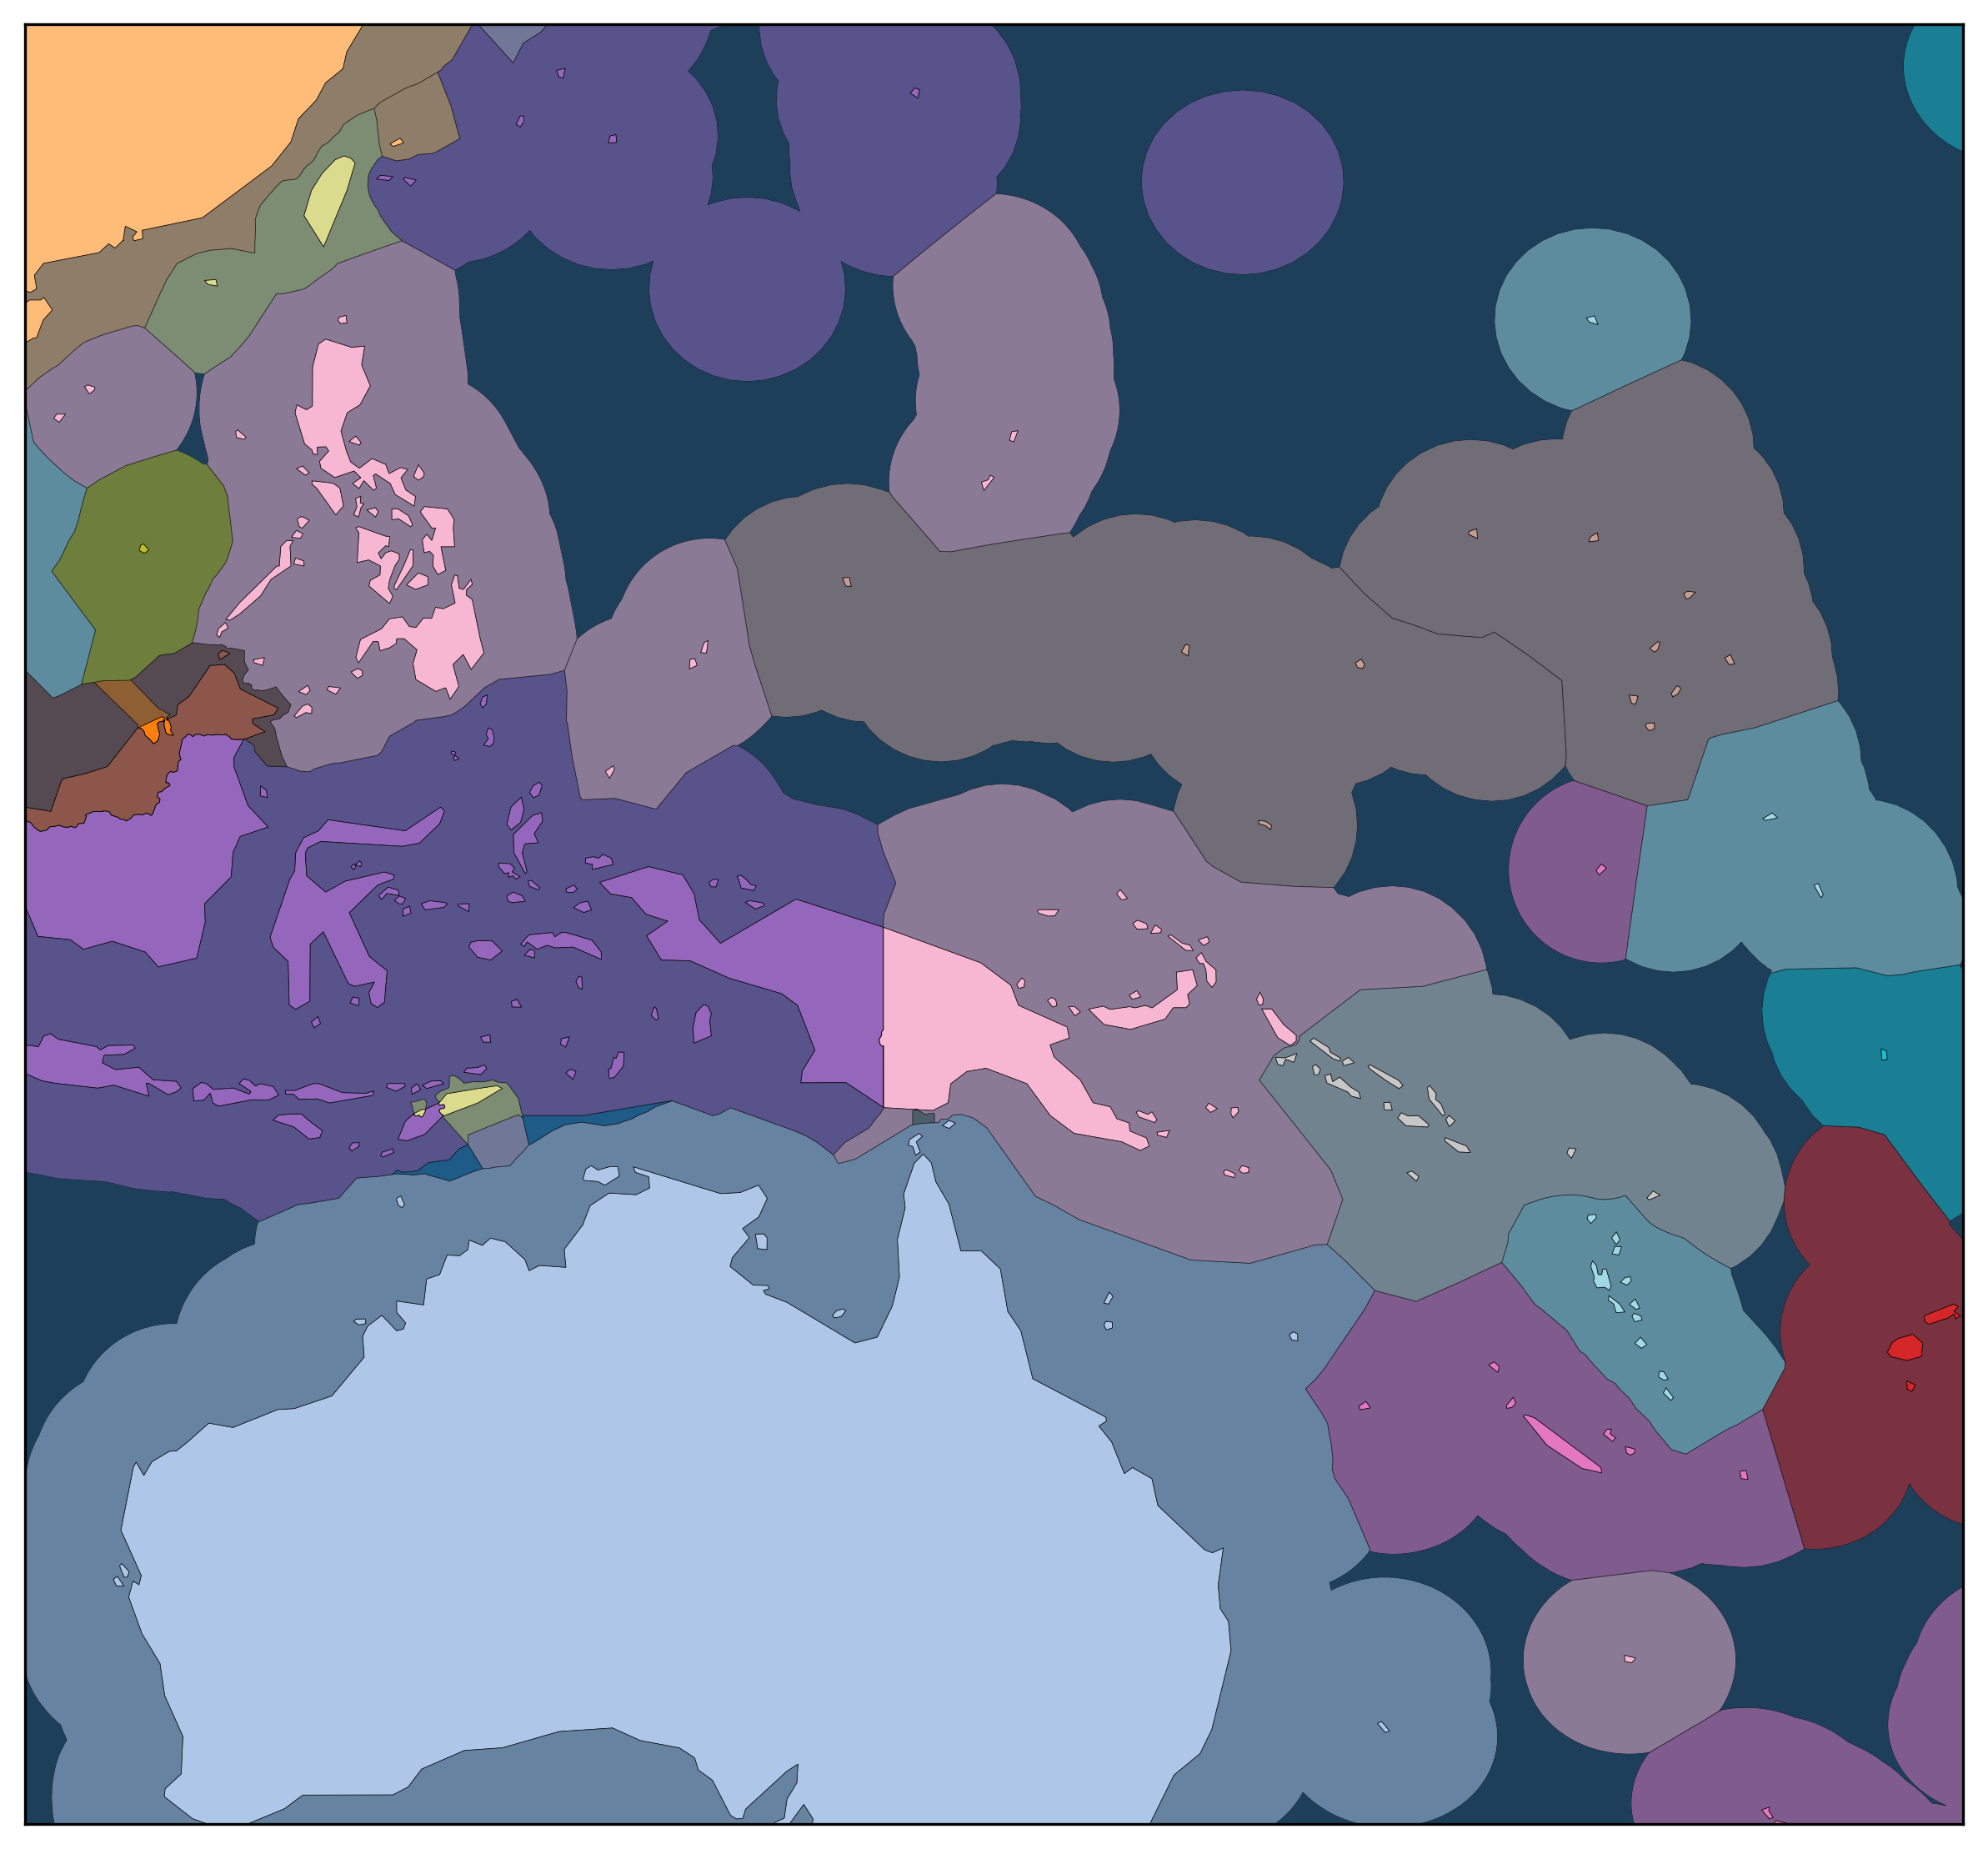

In [150]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=300)
EEZshapefile.set_geometry("continental_geometry", inplace=True)
EEZshapefile.plot(ax=ax, column="Country", edgecolor="black", linewidth=0.2, cmap="tab20")
# EEZshapefile.plot(ax=ax, color="lightgray", edgecolor="white", linewidth=0.2)

EEZshapefile.set_geometry("marine_geometry", inplace=True)
# EEZshapefile.plot(ax=ax, color="lightblue", edgecolor="white", linewidth=0.5)
EEZshapefile.plot(ax=ax, column="Country", edgecolor="black", linewidth=0.2, cmap="tab20", alpha=0.5)

EEZshapefile.loc[EEZshapefile.Country == "-1"].plot(ax=ax, color="#1e3f5a", linewidth=0.5)

# remove the axis
# ax.axis("off")
ax.set_facecolor("#1e3f5a")

ax.set_xlim(-180, 180)
ax.set_ylim(-90, 90)

ax.set_xticks([])
ax.set_yticks([])
fig.savefig("/home/gorka/Documents/EEZ.png", dpi=300, bbox_inches="tight")

ax.set_xlim(110, 180)
ax.set_ylim(-35, 30)
fig.savefig("/home/gorka/Documents/EEZ_zoom.png", dpi=300, bbox_inches="tight")


In [147]:
EEZshapefile

,ISO_3digit,Country,continental_geometry,EEZ_geometry,marine_geometry
0,-,Conflict zone Japan/Russia,"MULTIPOLYGON (((145.56500 43.99100, 145.63900 ...","POLYGON ((149.156571113 45.49545062500005, 149...","POLYGON ((149.15657 45.49545, 149.15924 45.486..."
1,-,Conflict zone Japan/South Korea,POLYGON EMPTY,"POLYGON ((134.2216315950001 39.87854129500005,...","POLYGON ((134.22163 39.87854, 134.23452 39.539..."
2,-,Joint regime Japan/Korea,POLYGON EMPTY,"POLYGON ((126.2457067390001 30.13313987000004,...","POLYGON ((126.24571 30.13314, 126.09167 30.303..."
3,-,Conflict zone China/Japan/Taiwan,"POLYGON ((123.54600 25.88900, 123.68100 25.711...","POLYGON ((122.900096165 25.22987522200003, 122...","POLYGON ((122.90010 25.22988, 122.89410 25.255..."
4,-,Spratly Islands,"POLYGON ((114.28500 11.23300, 114.48200 11.009...","POLYGON ((112.2398926440001 13.24706771000007,...","POLYGON ((112.23989 13.24707, 112.31403 13.297..."
...,...,...,...,...,...
257,SSD,South Sudan,"POLYGON ((34.09138 9.48753, 34.09416 9.45472, ...","POLYGON ((34.09138136600006 9.487534912000058,...",POLYGON EMPTY
258,VTC,Vatican City,"POLYGON ((12.45669 41.90139, 12.45014 41.90089...","POLYGON ((12.45669125900002 41.90139120600003,...",POLYGON EMPTY
259,ITA,Italy,"MULTIPOLYGON (((12.13302 47.01256, 12.13611 46...","POLYGON ((12.13301820000004 47.01256413000004,...","MULTIPOLYGON (((13.80222 45.58639, 13.72157 45..."
260,KIR,Kiribati,"MULTIPOLYGON (((-159.39900 4.06500, -159.10400...","POLYGON ((-159.374622539 7.917728175000036, -1...","POLYGON ((-159.37462 7.91773, -159.37462 7.917..."


In [148]:
EEZshapefile.explore(
    # column="Country",  # make choropleth based on "BoroName" column
    # tooltip="BoroName",  # show "BoroName" value in tooltip (on hover)
    # popup=True,  # show all values in popup (on click)
    # tiles="CartoDB positron",  # use "CartoDB positron" tiles
    # cmap="random_cmap",  # use "Set1" matplotlib colormap
    # style_kwds=dict(color="black"),  # use black outline
)

TypeError: Object of type Polygon is not JSON serializable

KeyError: 'Income'

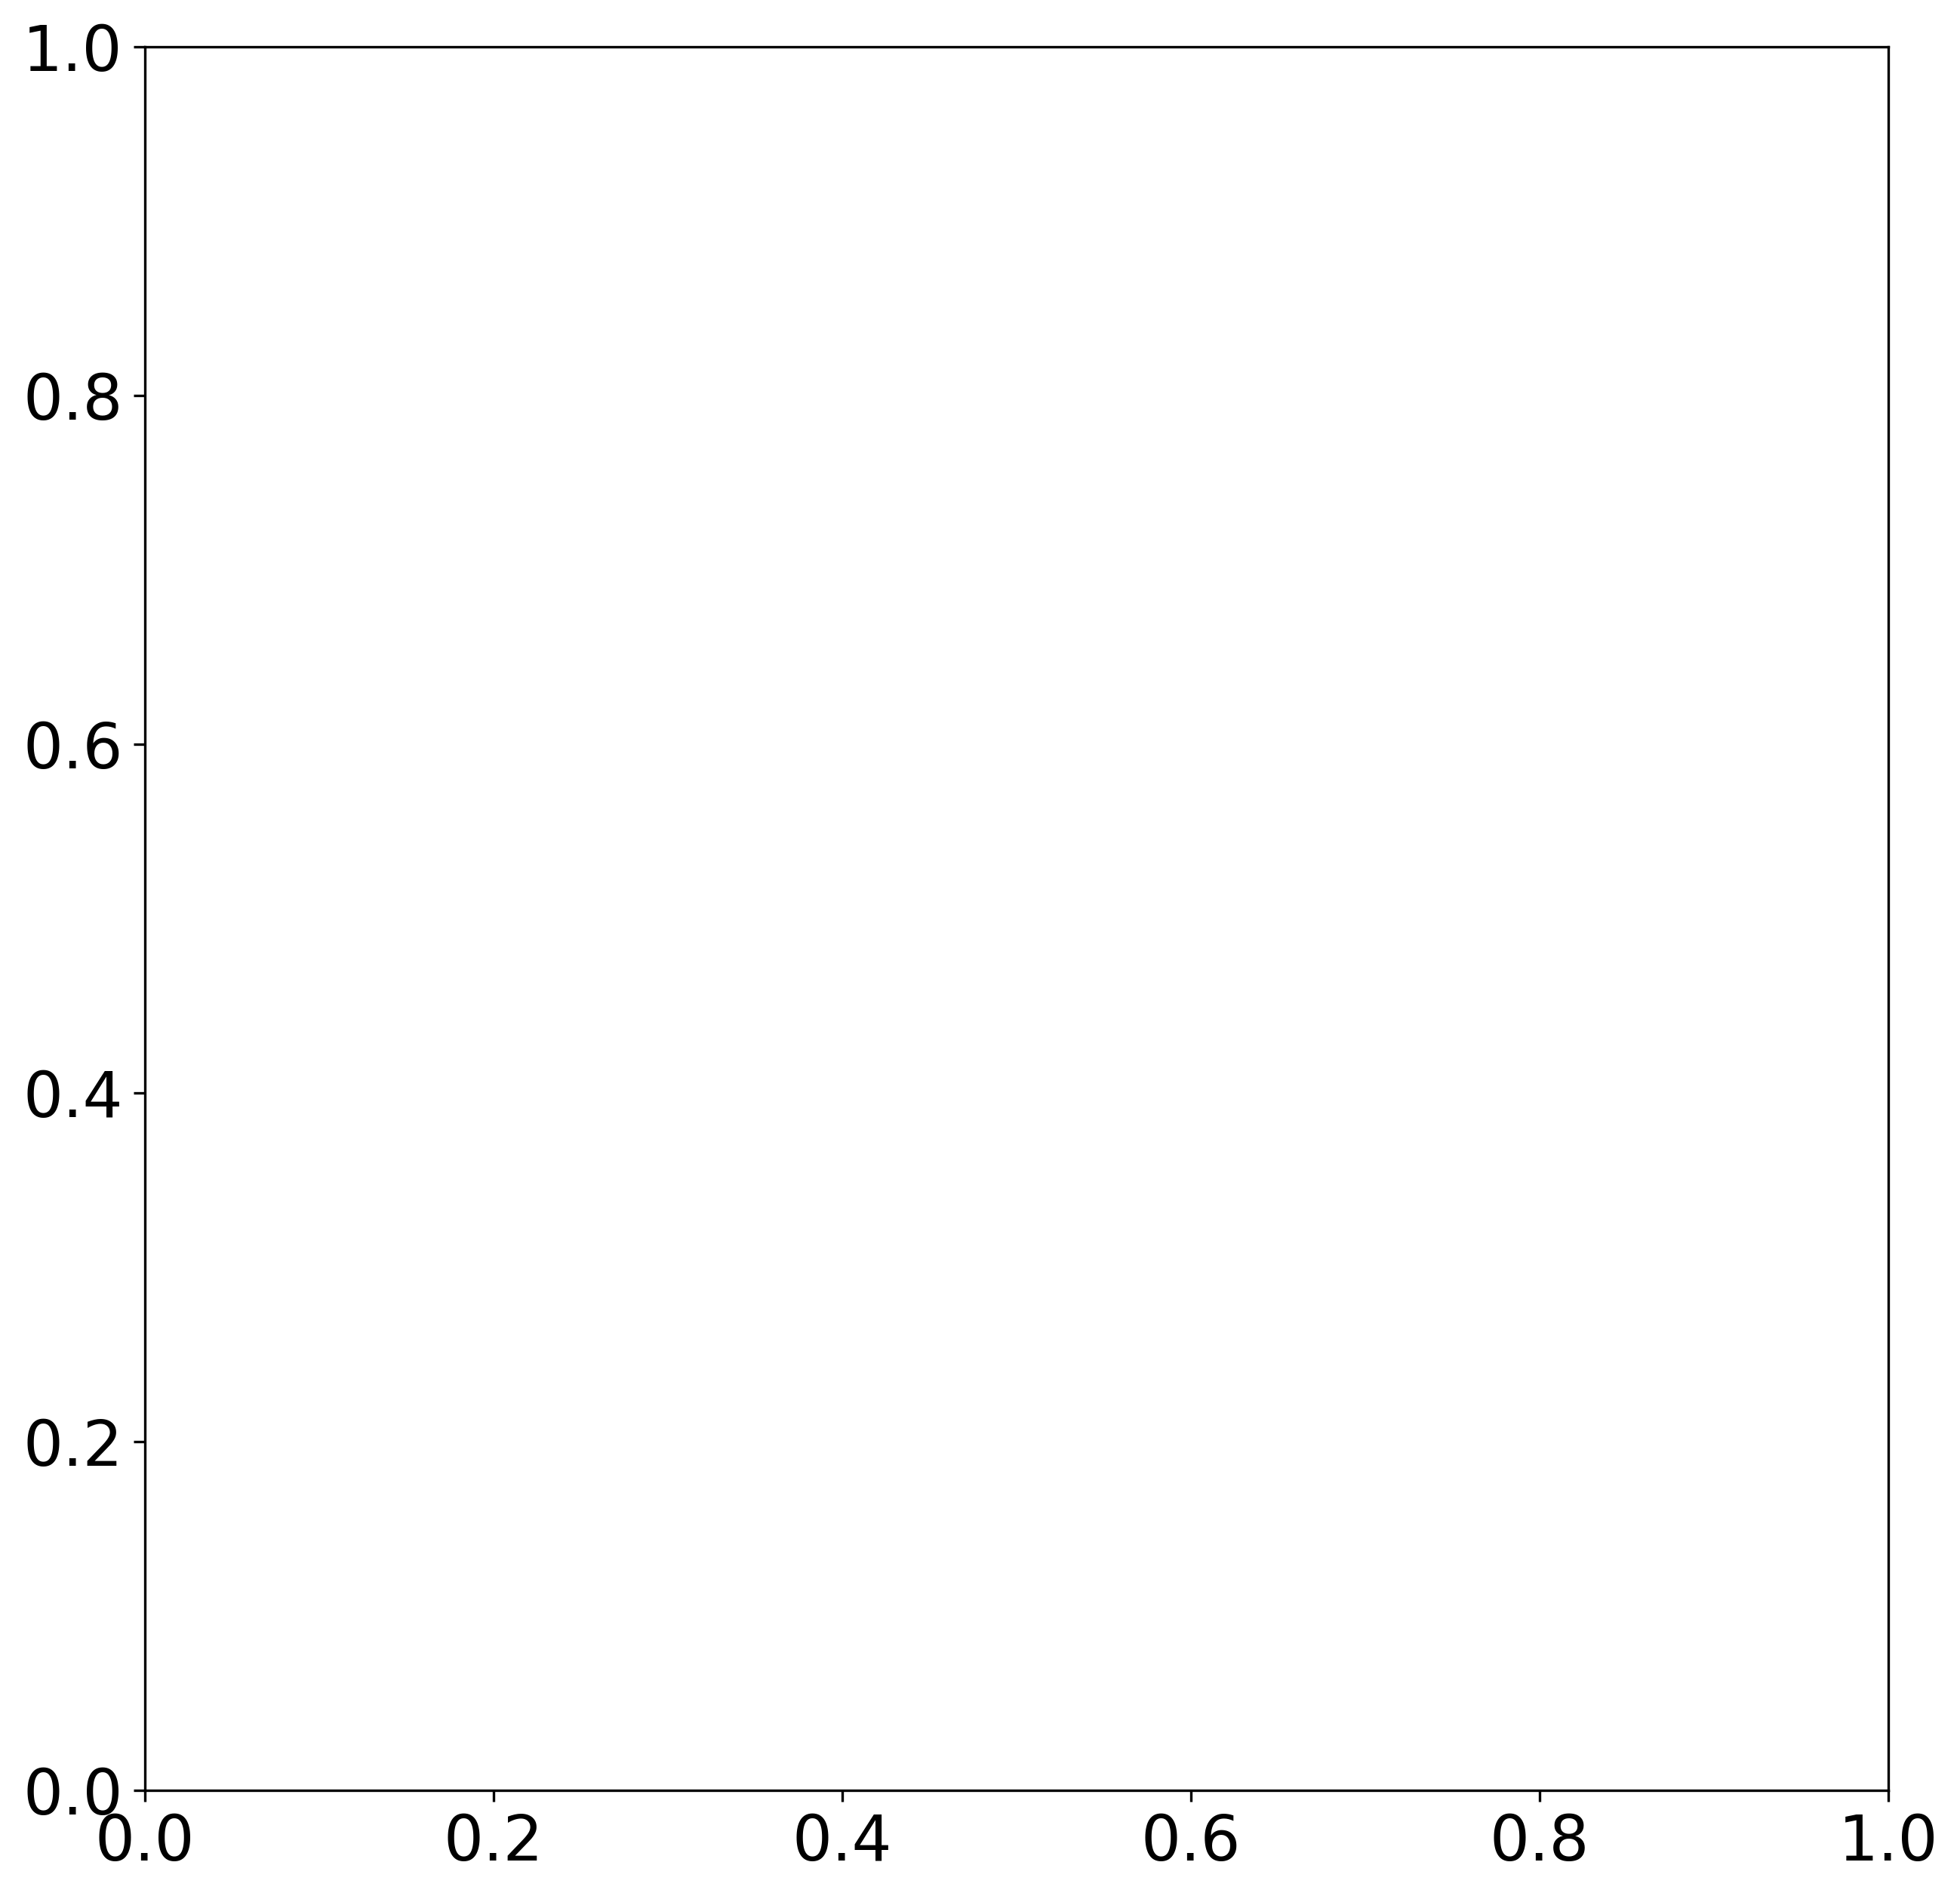

In [136]:
income_colors = [(189/255, 42/255, 118/255, 0.8), (223/255, 105/255, 166/255, 0.8), (103/255, 235/255, 127/255, 0.8), (0, 161/255, 29/255, 0.8)]
income_cmap = dpy.get_colormap(income_colors)
income_cmap

fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=300)
EEZshapefile.set_geometry("continental_geometry").plot(column="Income", cmap=income_cmap, ax=ax)
ContShape.boundary.plot(ax=ax, color="black", linewidth=0.5)
# make a manual legend an place it outside the map, to the lower left
legend_elements = [Patch(facecolor=income_colors[0], edgecolor='k', label='Low income'),
                   Patch(facecolor=income_colors[1], edgecolor='k', label='Lower middle income'),
                   Patch(facecolor=income_colors[2], edgecolor='k', label='Upper middle income'),
                   Patch(facecolor=income_colors[3], edgecolor='k', label='High income')]

ax.legend(handles=legend_elements, loc='upper left', title="Income group", bbox_to_anchor=(1, 1), fontsize=15, title_fontsize=15)

ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim(-180, 180)
ax.set_ylim(-90, 90)
ax.set_facecolor("lightgray")

In [6]:
# write a dictionary that maps Country to ISO_3digit and save it as "eez_to_iso3.csv"

eez_to_iso3 = dict(zip(EEZshapefile.Country, EEZshapefile.ISO_3digit))

with open("../data/eez_to_iso3.csv", "w") as f:  
    f.write("Country;ISO_3digit\n")
    for k, v in eez_to_iso3.items():
        f.write(f"{k};{v}\n")

We will use the intersection between the continental shelf and the EEZs to define the continental and oceanic domains of the contries. It could also be possible to search for another dataset with the countries shapefiles, but by doing so we could find some inconsistencies with the EEZ shapefiles, such as the countries names, codes, resolution, definition of conflict zones, threatment of dependant areas, etc.

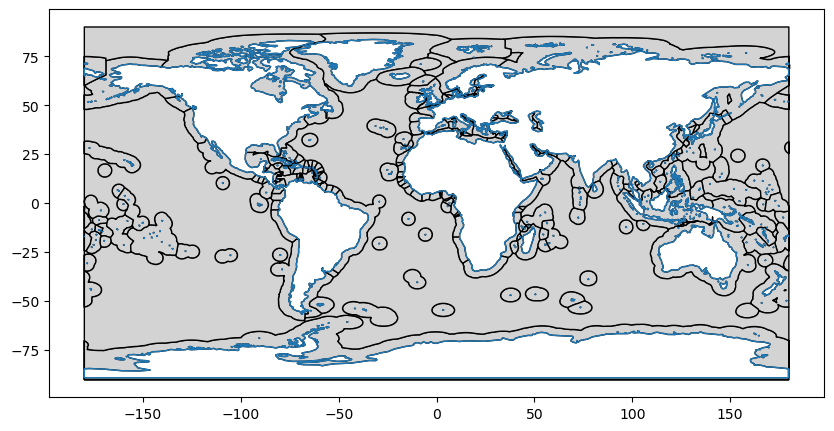

In [7]:

fig, ax = plt.subplots(figsize=(10, 10))
EEZshapefile.plot(color="lightgrey", edgecolor="black", ax=ax)
Continets.plot(color=(0,0,0,0), edgecolor="tab:blue", ax=ax)
plt.show()

# # repeat the plot changing the crs of the EEZshapefile to a equal area projection crs
# fig, ax = plt.subplots(figsize=(10, 10))
# EEZshapefile.to_crs("ESRI:54009").plot(color="lightgrey", edgecolor="black", ax=ax)
# Continets.plot(color=(0,0,0,0), edgecolor="tab:blue", ax=ax)
# plt.show()


In [8]:
trajectories_df = pd.read_csv("../data/megamove_v21_timecell_format0.csv")

trajectories_df

,newid,LATITUDE,LONGITUDE,dt_f0,timestay,c05
0,0,-66.666670,140.016670,41230.004861,0.047691,33760
1,0,-66.662651,140.003204,41230.100243,0.057934,33760
2,0,-66.662598,140.003143,41230.120729,0.020556,33760
3,0,-66.662636,140.003204,41230.141354,0.020631,33760
4,0,-66.662605,140.003204,41230.161991,0.020828,33760
...,...,...,...,...,...,...
6854435,12787,-3.001852,55.677597,40539.013194,0.999306,125031
6854436,12787,0.454047,52.550244,40540.022222,0.753819,130065
6854437,12787,1.173344,53.110498,40540.520833,0.497569,131506
6854438,12787,-2.466126,54.420246,40541.017361,0.248264,126468


In [9]:
metadata_df = pd.read_csv("../data/megamove_v21_metadatamore_taxa.csv")

id_to_species = dict(zip(metadata_df.NewID, metadata_df.Species))
metadata_df.Species.value_counts().to_frame().reset_index().Species.values

array(['Audouins gull', 'Corys shearwater', 'Northern gannet',
       'Black-browed albatross', 'Little penguin', 'Bullers albatross',
       'Southern elephant seal', 'Grey-headed albatross',
       'Australian sea lion', 'Macaroni penguin', 'Loggerhead turtle',
       'Chinstrap penguin', 'Scopolis shearwater', 'Blue shark',
       'Whale shark', 'Shortfin mako shark', 'Tiger shark',
       'Leatherback turtle', 'Wandering albatross',
       'Northern elephant seal', 'Humpback whale', 'Salmon shark',
       'Short-finned pilot whale', 'King eider', 'Adelie penguin',
       'White shark', 'Hawksbill turtle', 'California sea lion',
       'Masked booby', 'Blue whale', 'Green turtle', 'Laysan albatross',
       'Long-nosed fur seal', 'Black-footed albatross', 'Trindade petrel',
       'Oceanic whitetip shark', 'Ringed seal', 'Harbour seal',
       'Northern fulmar', 'Manx shearwater', 'Red-tailed tropic bird',
       'Thick-billed murre', 'Polar bear', 'Common eider',
       'Galapagos 

<Axes: xlabel='LONGITUDE', ylabel='LATITUDE'>

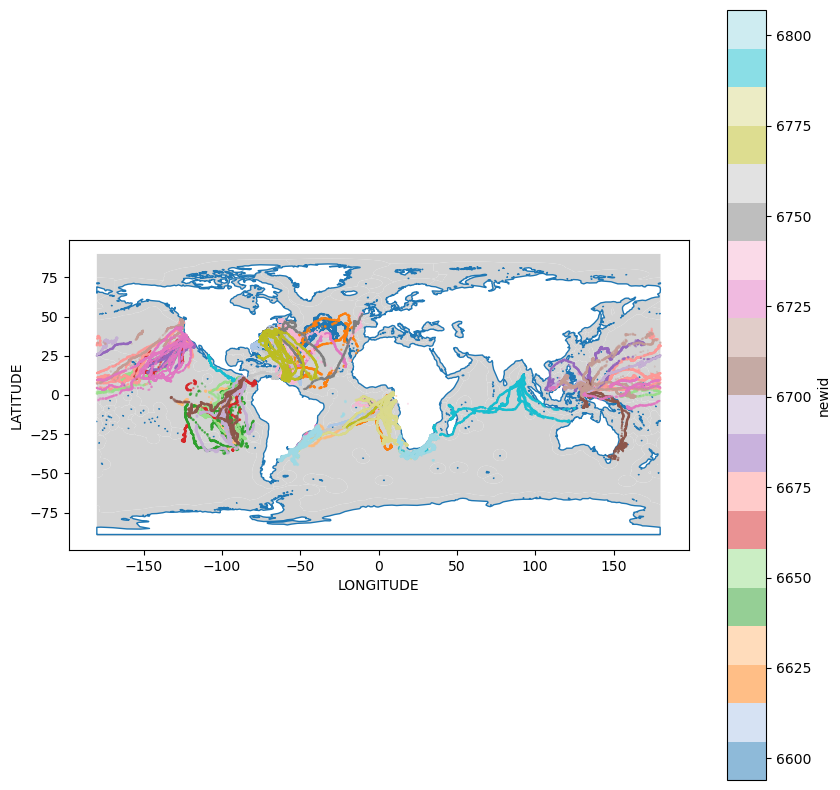

In [10]:
selected_sp = metadata_df[metadata_df.Species == "Leatherback turtle"].NewID
fig, ax = plt.subplots(figsize=(10, 10))
EEZshapefile.plot(color="lightgrey", edgecolor="none", ax=ax)
Continets.plot(color=(0,0,0,0), edgecolor="tab:blue", ax=ax)
# plt.show()
trajectories_df[trajectories_df.newid.isin(selected_sp)].plot.scatter(x="LONGITUDE", y="LATITUDE", c="newid", s="timestay", cmap="tab20", alpha=0.5, ax=ax)

In [11]:
trajectories_df

,newid,LATITUDE,LONGITUDE,dt_f0,timestay,c05
0,0,-66.666670,140.016670,41230.004861,0.047691,33760
1,0,-66.662651,140.003204,41230.100243,0.057934,33760
2,0,-66.662598,140.003143,41230.120729,0.020556,33760
3,0,-66.662636,140.003204,41230.141354,0.020631,33760
4,0,-66.662605,140.003204,41230.161991,0.020828,33760
...,...,...,...,...,...,...
6854435,12787,-3.001852,55.677597,40539.013194,0.999306,125031
6854436,12787,0.454047,52.550244,40540.022222,0.753819,130065
6854437,12787,1.173344,53.110498,40540.520833,0.497569,131506
6854438,12787,-2.466126,54.420246,40541.017361,0.248264,126468


In [13]:
agg_data = pd.read_csv("../data/agg_data.csv")
agg_data



,newid,Species,EEZ,timestay (1/30days),timestay^2 (1/30days)
0,0,0,8,30.000000,900.000000
1,1,0,8,30.000000,900.000000
2,2,0,8,30.000000,900.000000
3,3,0,8,30.000000,900.000000
4,4,0,8,30.000000,900.000000
...,...,...,...,...,...
22784,12787,110,141,1.502173,2.256524
22785,12787,110,147,0.477632,0.228132
22786,12787,110,174,0.410633,0.168619
22787,12787,110,202,10.525889,110.794334


In [107]:
species_to_taxa = dict(zip(metadata_df.Species, metadata_df.Taxa))
species_to_taxa

{'Adelie penguin': 'Penguins',
 'Arctic Herring gull': 'Birds',
 'Ascension frigatebird': 'Birds',
 'Atlantic puffin': 'Birds',
 'Audouins gull': 'Birds',
 'Australian fur seal': 'Seals',
 'Australian sea lion': 'Seals',
 'Baraus petrel': 'Birds',
 'Beluga whale': 'Cetaceans',
 'Black-browed albatross': 'Birds',
 'Black-footed albatross': 'Birds',
 'Blacktip shark': 'Fishes',
 'Blue shark': 'Fishes',
 'Blue whale': 'Cetaceans',
 'Bottlenose dolphin': 'Cetaceans',
 'Bowhead whale': 'Cetaceans',
 'Broad-billed prion': 'Birds',
 'Broadnose sevengill shark': 'Fishes',
 'Bull shark': 'Fishes',
 'Bullers albatross': 'Birds',
 'California sea lion': 'Seals',
 'Chinstrap penguin': 'Penguins',
 'Common eider': 'Birds',
 'Common murre': 'Birds',
 'Common thresher shark': 'Fishes',
 'Copper shark': 'Fishes',
 'Corys shearwater': 'Birds',
 'Crabeater seal': 'Seals',
 'Crested tern': 'Birds',
 'Dugong': 'Sirenians',
 'Dusky shark': 'Fishes',
 'Emperor penguin': 'Penguins',
 'Fin whale': 'Cetaceans'

In [109]:
summary_df = agg_data.copy()
summary_df.Species = summary_df.newid.map(id_to_species)
summary_df["Taxa"] = summary_df.Species.map(species_to_taxa)
summary_df

,newid,Species,EEZ,timestay (1/30days),timestay^2 (1/30days),Taxa
0,0,Adelie penguin,8,30.000000,900.000000,Penguins
1,1,Adelie penguin,8,30.000000,900.000000,Penguins
2,2,Adelie penguin,8,30.000000,900.000000,Penguins
3,3,Adelie penguin,8,30.000000,900.000000,Penguins
4,4,Adelie penguin,8,30.000000,900.000000,Penguins
...,...,...,...,...,...,...
22784,12787,White-tailed tropic bird,141,1.502173,2.256524,Birds
22785,12787,White-tailed tropic bird,147,0.477632,0.228132,Birds
22786,12787,White-tailed tropic bird,174,0.410633,0.168619,Birds
22787,12787,White-tailed tropic bird,202,10.525889,110.794334,Birds


In [125]:
summary_df.loc[:, ["newid", "Species"]].drop_duplicates().Species.value_counts().to_frame().reset_index()

,Species,count
0,Audouins gull,1229
1,Corys shearwater,945
2,Northern gannet,767
3,Black-browed albatross,543
4,Little penguin,532
...,...,...
106,Longfin mako shark,1
107,Dusky shark,1
108,Sandbar shark,1
109,Broadnose sevengill shark,1


In [129]:
summary_df.loc[:, ["newid", "Species", "Taxa"]].drop_duplicates().Taxa.value_counts().to_frame().reset_index()

,Taxa,count
0,Birds,6224
1,Fishes,1721
2,Seals,1691
3,Penguins,1322
4,Turtles,835
5,Cetaceans,741
6,Polar bears,65
7,Sirenians,27


In [132]:
summary_df.loc[:, ["Taxa", "Species"]].drop_duplicates().Taxa.value_counts().to_frame()

,count
Taxa,
Birds,39
Fishes,26
Seals,16
Cetaceans,14
Turtles,7
Penguins,6
Sirenians,2
Polar bears,1


In [113]:
summary_df.loc[:, ["Taxa", "Species"]].value_counts().to_frame().to_csv("../data/taxa_species_summary.csv")

In [114]:
summary_df.loc[:, ["Taxa", "Species"]].drop_duplicates().Taxa.value_counts().to_frame()

,count
Taxa,
Birds,39
Fishes,26
Seals,16
Cetaceans,14
Turtles,7
Penguins,6
Sirenians,2
Polar bears,1


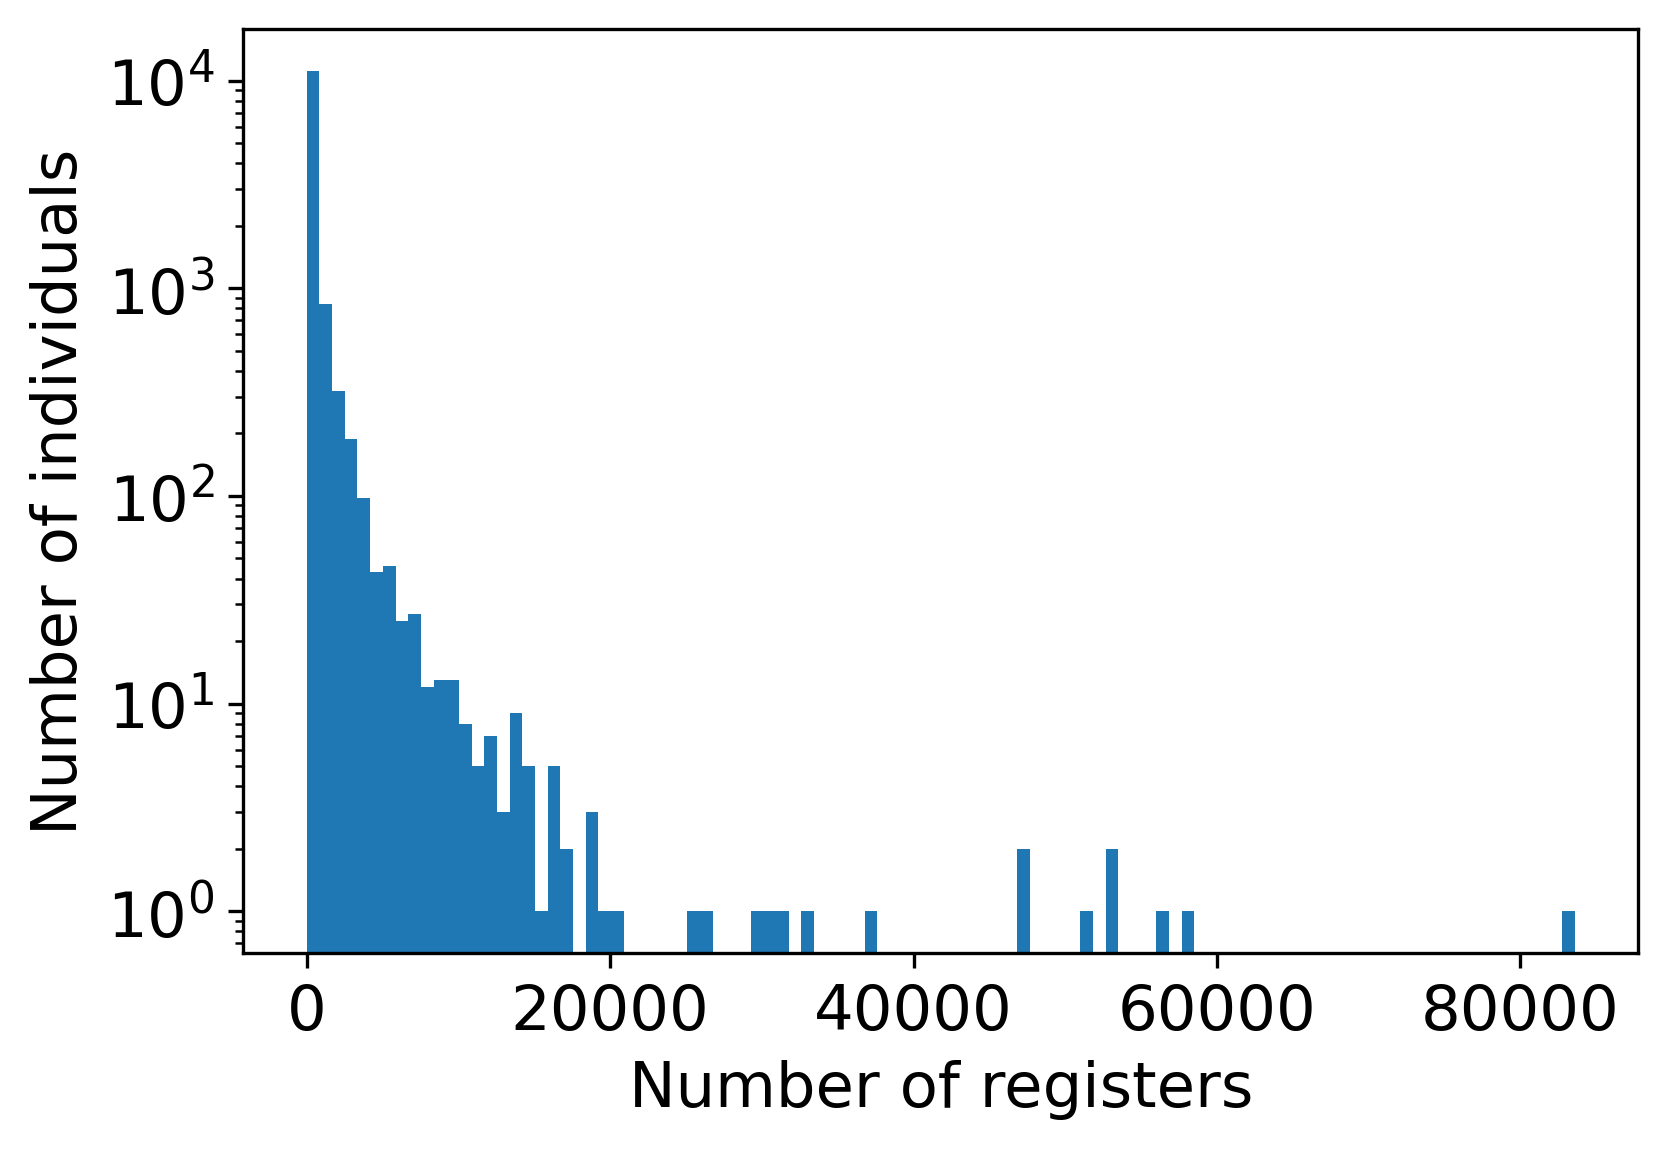

[1.000000e+00 8.369900e+02 1.672980e+03 2.508970e+03 3.344960e+03
 4.180950e+03 5.016940e+03 5.852930e+03 6.688920e+03 7.524910e+03
 8.360900e+03 9.196890e+03 1.003288e+04 1.086887e+04 1.170486e+04
 1.254085e+04 1.337684e+04 1.421283e+04 1.504882e+04 1.588481e+04
 1.672080e+04 1.755679e+04 1.839278e+04 1.922877e+04 2.006476e+04
 2.090075e+04 2.173674e+04 2.257273e+04 2.340872e+04 2.424471e+04
 2.508070e+04 2.591669e+04 2.675268e+04 2.758867e+04 2.842466e+04
 2.926065e+04 3.009664e+04 3.093263e+04 3.176862e+04 3.260461e+04
 3.344060e+04 3.427659e+04 3.511258e+04 3.594857e+04 3.678456e+04
 3.762055e+04 3.845654e+04 3.929253e+04 4.012852e+04 4.096451e+04
 4.180050e+04 4.263649e+04 4.347248e+04 4.430847e+04 4.514446e+04
 4.598045e+04 4.681644e+04 4.765243e+04 4.848842e+04 4.932441e+04
 5.016040e+04 5.099639e+04 5.183238e+04 5.266837e+04 5.350436e+04
 5.434035e+04 5.517634e+04 5.601233e+04 5.684832e+04 5.768431e+04
 5.852030e+04 5.935629e+04 6.019228e+04 6.102827e+04 6.186426e+04
 6.270025e

In [100]:
ids_registers = trajectories_df.newid.value_counts().to_frame().reset_index()["count"].values

fig, ax = plt.subplots(figsize=(6,4), dpi=300)
counts, bins, patches = ax.hist(ids_registers, bins=100, log=True)
plt.xlabel("Number of registers")
plt.ylabel("Number of individuals")
# plt.xscale("log")
# set the fontsize to 15
plt.rc('font', size=20)
plt.show()
print(bins)
print(counts)

In [135]:
trajectories_df

,newid,LATITUDE,LONGITUDE,dt_f0,timestay,c05
0,0,-66.666670,140.016670,41230.004861,0.047691,33760
1,0,-66.662651,140.003204,41230.100243,0.057934,33760
2,0,-66.662598,140.003143,41230.120729,0.020556,33760
3,0,-66.662636,140.003204,41230.141354,0.020631,33760
4,0,-66.662605,140.003204,41230.161991,0.020828,33760
...,...,...,...,...,...,...
6854435,12787,-3.001852,55.677597,40539.013194,0.999306,125031
6854436,12787,0.454047,52.550244,40540.022222,0.753819,130065
6854437,12787,1.173344,53.110498,40540.520833,0.497569,131506
6854438,12787,-2.466126,54.420246,40541.017361,0.248264,126468


In [45]:
trajectories_df

,newid,LATITUDE,LONGITUDE,dt_f0,timestay,c05
0,0,-66.666670,140.016670,41230.004861,0.047691,33760
1,0,-66.662651,140.003204,41230.100243,0.057934,33760
2,0,-66.662598,140.003143,41230.120729,0.020556,33760
3,0,-66.662636,140.003204,41230.141354,0.020631,33760
4,0,-66.662605,140.003204,41230.161991,0.020828,33760
...,...,...,...,...,...,...
6854435,12787,-3.001852,55.677597,40539.013194,0.999306,125031
6854436,12787,0.454047,52.550244,40540.022222,0.753819,130065
6854437,12787,1.173344,53.110498,40540.520833,0.497569,131506
6854438,12787,-2.466126,54.420246,40541.017361,0.248264,126468
